In [1]:
import pandas as pd
import numpy as np
import math
from graphviz import Digraph
from itertools import product
from uuid import uuid4

In [2]:
from sklearn import tree
from sklearn.metrics import accuracy_score

In [3]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Callable, Any

In [4]:
@dataclass
class Node:
    label: str
    attr: str
    attr_value: Any
    branches: list[Node]
    _id: uuid.UUID = field(default_factory=uuid4)

In [284]:
class ID3:
    def __init__(self, split_func: Callable[[pd.DataFrame, pd.DataFrame], float], vote_func: Callable[pd.DataFrame, str]):
        self.split_func = split_func
        self.vote_func = vote_func
        self.root: Node = None
        self.g = Digraph('Tree')
        self.label_map = None
        
    def generate_label_idx(self, labels):
        self.label_map = {}
        for i, label in enumerate(labels):
            self.label_map[label] = i+1
            
    def predict(self, X: pd.DataFrame):
        def _predict_tuple(x: pd.Series):
            node = list(filter(lambda n: n.attr_value == x[n.attr], self.root.branches))[0]
            if node.label is not None:
                return node.label
            while node.label is None:
                node = list(filter(lambda n: n.attr_value == x[n.attr], node.branches))[0]
                if node.label is not None:
                    return node.label
            
        return X.apply(_predict_tuple, axis=1)
        
    def fit(self, X: pd.DataFrame, y_col: str, root: Node = None) -> Node:
        cols = X.columns.to_list()
        cols.remove(y_col)
        y = X.loc[:, y_col]
        labels = set(y.to_list())
        
        if self.label_map is None:
            self.generate_label_idx(labels)
        
        if self.root == None:
            root = Node(label=None, attr="", attr_value=None, branches=[])
            self.root = root
        
        if len(labels) < 2:
            root.label = labels.pop()
            return root
        
        if len(cols) < 1:
            root.label = self.vote_func(y)
            #y.value_counts().idxmax() # vote
            return root
        
        score_attr = { c: self.split_func(X.loc[:, c], y) for c in cols } # score per each attr
        # here i changed max per min because in our info gain we don't consider the entropy before the partition
        # and we want to maximize this result (entropy before - entropy of attribute A), to maximize it we just
        # need to minimize entropy of attribute A.
        best_attr = min(score_attr, key=score_attr.get)
                                                        
        attr_values = set(X.loc[:, best_attr].values)
        
        for v in attr_values:
            child = Node(attr=best_attr, attr_value=v, branches=[], label=None)
            root.branches.append(child)
            
            subset = X[X[best_attr] == v]
            subset = subset.loc[:, subset.columns != best_attr] # removing the best attr from the data
            self.fit(subset, y_col, child)
        
    def __str__(self):
        return self._pprint(self.root)
        
    def _pprint(self, node, level=0):
        if node is None:
            return ""
        
        string = "-"*2*level + f" attr: {node.attr}, attr_val: {node.attr_value}, label: {node.label}\n"
        for n in node.branches:
            string = string + self._pprint(n, level=level+1)
        
        return string
    
    def _draw_tree(self, root, level=0):
        if root is None:
            return
        
        if root is self.root:
            with self.g.subgraph(name=f'sub_{level}') as c:
                c.attr('node',shape='circle', fillcolor='white', color='black')
                c.node(f"{root._id}", label=f"root")
        
        for node in root.branches:
            with self.g.subgraph(name=f'sub_{level}') as c:
                if node.label is not None:
                    c.attr('node', rank='same', style='filled', shape='oval', fillcolor=f'/accent8/{self.label_map[node.label]}')
                else:
                    c.attr('node', rank='same', shape='oval', fillcolor='white', color='black')
                    
                c.node(f"{node._id}", label=f"{node.attr}\n{node.attr_value}")
                c.edge(f"{root._id}", f"{node._id}")
                
        for node in root.branches:
            self._draw_tree(node, level=level+1)
            
    def draw(self):
        self._draw_tree(self.root)
        display(self.g)

## Default Split and Vote functions

Entropy, where Pi is the frequentist probability of an element has label i in the data
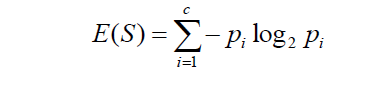

In [307]:
def _entropy(X: pd.DataFrame, y: pd.DataFrame) -> float:
    pi = y[X.index].value_counts(normalize=True) # relative frequency of labels in an attribute value a\inA
    return -sum([p*math.log2(p) for p in pi])

def info_gain(X: pd.DataFrame, y: pd.DataFrame) -> float: # it's not really the info gain but the entropy of attr A
    counts = X.value_counts(normalize=True).to_dict()
    return (sum([v*_entropy(X[X == k], y) for k,v in counts.items()])) # gain of an attribute

In [308]:
def majority(y: pd.DataFrame):
    return y.value_counts().idxmax()

## DP Split and Vote function
Blum et al. 2005

In [377]:
from scipy.stats import laplace

def dp_info_gain(X: pd.DataFrame, y: pd.DataFrame, eps: float) -> float: # it's not really the info gain but the entropy of attr A
    noise = laplace.rvs(loc=0, scale=1/eps, size=X.unique().shape[0])
    counts = X.value_counts(normalize=True).to_dict()
    counts = { k: v + noise[i] for i,(k,v) in enumerate(counts.items())}
    return (sum([v*_entropy(X[X == k], y) for k,v in counts.items()])) # gain of an attribute

def dp_majority(y:pd.DataFrame, eps: float):
    noise = laplace.rvs(loc=0, scale=1/eps, size=y.unique().shape[0])
    return (y.value_counts() + noise).idxmax()

In [378]:
dp_info_gain(X['sep_len'], y, 1)

-6.401483084203237

In [374]:
#from info_gain import info_gain as info
#
#X = pd.read_csv('play_tennis.csv')
#ig  = info.info_gain(X.loc[:,'Wind'], X.loc[:,'Play Tennis'])
#a = info_gain(X.loc[:,'Wind'], X.loc[:,'Play Tennis'])
#b = dp_info_gain(X.loc[:,'Wind'], X.loc[:,'Play Tennis'], eps)
#
#print('test', ig, a, b)

Accuracy: 1.0


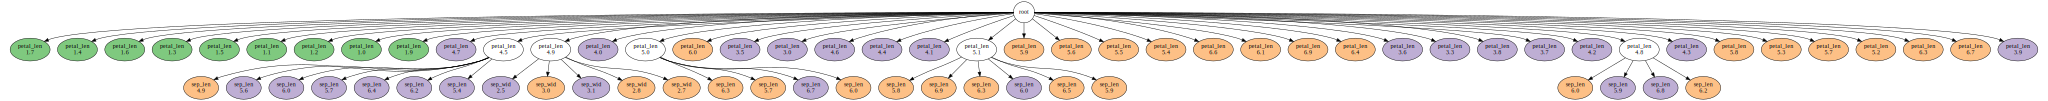

In [344]:
tree = ID3(info_gain, majority)
tree.fit(X, 'target')
y_pred = tree.predict(X)
acc = accuracy_score(X['target'], y_pred)
print(f'Accuracy: {acc}')
tree.draw()

## Testing

In [369]:
from sklearn.datasets import load_iris
data = load_iris()

In [370]:
X = pd.DataFrame(data.data, columns=data.feature_names)

In [371]:
X.columns = ["sep_len", "sep_wid", "petal_len", "petal_wid"]
X['target'] = data['target']

Accuracy: 1.0


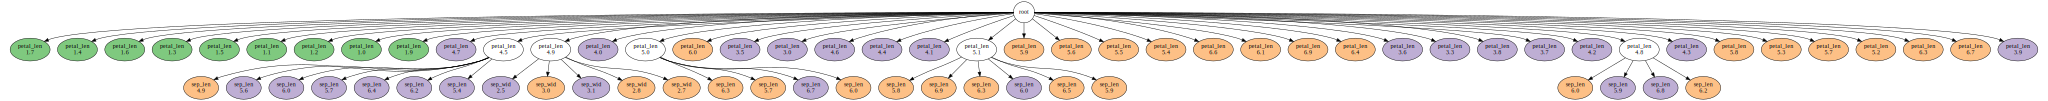

In [372]:
tree = ID3(info_gain, majority)
tree.fit(X, 'target')
y_pred = tree.predict(X)
acc = accuracy_score(X['target'], y_pred)
print(f'Accuracy: {acc}')
tree.draw()

In [16]:
outlook = 'overcast,overcast,overcast,overcast,rainy,rainy,rainy,rainy,rainy,sunny,sunny,sunny,sunny,sunny'.split(',')
temp = 'hot,cool,mild,hot,mild,cool,cool,mild,mild,hot,hot,mild,cool,mild'.split(',')
humidity = 'high,normal,high,normal,high,normal,normal,normal,high,high,high,high,normal,normal'.split(',')
windy = 'FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE'.split(',')
play = 'yes,yes,yes,yes,yes,yes,no,yes,no,no,no,no,yes,yes'.split(',')
dataset ={'outlook':outlook,'temp':temp,'humidity':humidity,'windy':windy,'play':play}
df = pd.DataFrame(dataset,columns=['outlook','temp','humidity','windy','play'])

In [17]:
tree = ID3(info_gain, majority)
tree.fit(df, 'play')
print(tree)

 attr: , attr_val: None, label: None
-- attr: outlook, attr_val: overcast, label: yes
-- attr: outlook, attr_val: sunny, label: None
---- attr: humidity, attr_val: normal, label: yes
---- attr: humidity, attr_val: high, label: no
-- attr: outlook, attr_val: rainy, label: None
---- attr: windy, attr_val: FALSE, label: yes
---- attr: windy, attr_val: TRUE, label: no



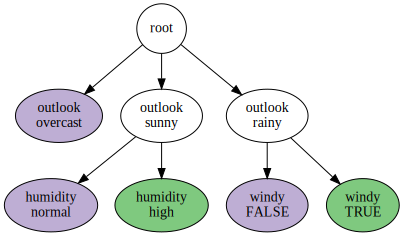

In [18]:
tree.draw()

In [ ]:
# df = pd.read_csv('adult.csv')

In [ ]:
# del df['fnlwgt']
# del df['age']
# df.head()

In [ ]:
# tree = ID3(info_gain)
# tree.fit(df, 'income')

In [ ]:
# tree.draw()

In [ ]:
# print(tree)